# Classification of NHL game data

## the idea

## theoretical background

As explained in chapter 13 in the book by Zaki and Meira [](#cite-zaki2014data), clustering is a way to group data into sets with common central points. The aim of clustering datasets is to inspect data structures which lay hidden to other statistical tools. Especially for multivariate datasets, a clustering may reveal interconnections between datapoints which may be hard to reveal starting from probabilistic measures, such as crosscorrelations. 

We use clustering methods on our purpose to see if there are similarities between games, judged from the cumulative statistics, so that they can be categorized together.

In [1]:
library(fpc)  
DATACAPTIONVEC <- c("ID","SEASON","DATE","TEAM1","TEAM2","WON","SCORE","SHOTS","FACEOFF","TAKEAWAY","GIVEAWAY","PIM","HITS","PPG","ATTENDANCE")

In the next step we read the input data as generated by the python class dataMiner.py. The input data consists of data with postfix Delta and Sum, with Sum data defined as $X_{\Delta}=X_{h}-X_{a}$ with $X_{h,a} \in X \in \mathbb{D}^{d}$ and $X_{\Sigma}=X_{h}+X_{a}$ with $X_{h,a} \in \mathbb{D}^{d}$ ($\mathbb{D}$ a mixture of binary and natural numbers), d dimensional home and away team statistics vectors. In our case every datasample has 16 entries,with 10 numerical attributes per dataset, giving d=10. The first 6 attributes of each dataset like season, game id and teams who played contain supplementery information and are important only in the preprocessing process. We may write our dataset as "set" $X_{\Delta,Sum} = F ( x_{won},x_{score},x_{shots},x_{faceoff},x_{takeaway},x_{giveaway},x_{pim},x_{hits},x_{ppg},x_{attendance} )$ with F a function of the datasets for home and away teams, as described above. $x_{won}$ takes binary values $x_{won} \in [0,1]$, 0 for loss and 1 for game won. The other attributes take integer values.

In [2]:
print("The categories stored in the data set are")
print(paste(DATACAPTIONVEC))

[1] "The categories stored in the data set are"
 [1] "ID"         "SEASON"     "DATE"       "TEAM1"      "TEAM2"     
 [6] "WON"        "SCORE"      "SHOTS"      "FACEOFF"    "TAKEAWAY"  
[11] "GIVEAWAY"   "PIM"        "HITS"       "PPG"        "ATTENDANCE"


In [3]:
nhlDataSum=data.frame()
nhlDataDelta=data.frame()
SeasonVector=c(2010,2011,2012,2014,2015,2016)
NumberOfSeasons=length(SeasonVector)
for(season in SeasonVector)
{
  tableName=paste("../dataSetsNHL/dataFileNhl_",season,"_regular_sum.dat",sep="")
  nhlDataS=read.table(tableName)
  colnames(nhlDataS) <- DATACAPTIONVEC
  nhlDataSum<-rbind(nhlDataSum,nhlDataS)
  tableName=paste("../dataSetsNHL/dataFileNhl_",season,"_regular_delta.dat",sep="")
  nhlDataS=read.table(tableName)
  colnames(nhlDataS) <- DATACAPTIONVEC
  nhlDataDelta<-rbind(nhlDataDelta,nhlDataS)
}
colnames(nhlDataSum) <- DATACAPTIONVEC
colnames(nhlDataDelta) <- DATACAPTIONVEC
print("The dataset read contains ")
print(paste(nrow(nhlDataDelta),ncol(nhlDataDelta)))
print("rows and columns.")
nhlDataM=as.matrix(cbind(nhlDataS$SHOTS,nhlDataS$FACEOFF,nhlDataS$HITS,nhlDataS$TAKEAWAY,nhlDataS$GIVEAWAY,nhlDataS$PIM,nhlDataS$PPG))
print(max(nhlDataM))
nhlDataM=as.matrix(cbind(nhlDataDelta$SHOTS,nhlDataDelta$FACEOFF,nhlDataDelta$HITS,nhlDataDelta$TAKEAWAY,nhlDataDelta$GIVEAWAY,nhlDataDelta$PIM,nhlDataDelta$PPG))
print(max(nhlDataM))

[1] "The dataset read contains "
[1] "6603 15"
[1] "rows and columns."
[1] 37
[1] 55


## some more data preprocessing

In this section we analyze overall game data and try to answer the question whether there is a clustering of game stats around goals scored, and if yes, how far the cluster stretches over all the D data categories. To this end we look at all the home games played and read the data categories into one data matrix.

The datavectors $X_{Sum},X_{\Delta}$ are now combined to give individual teams statistics. For home games we can simply add the two $X_{team,h}={1 \over 2} \{ X_{Sum} + X_{\Delta} \}$, for the away team stats we have to invert $X_{\Delta}$: $X_{team,a}={1 \over 2} \{ X_{Sum} - X_{\Delta} \}$, and finally add the two: $X_{team}=X_{team,h}+X_{team,a}$ to obtain the overall game stats. We are doing this for all the teams contained in the statistics, which are the following:

In [75]:
teams <- nhlDataDelta$TEAM1
LISTOFTEAMS=unique(teams)
print("we have the following teams")
print(LISTOFTEAMS)

[1] "we have the following teams"
 [1] BOS       TOR       COL       CGY       CAR       PIT       CHI      
 [8] DET       BUF       NJ        NYI       NYR       WSH       ATLANTA  
[15] FLA       CBJ       DAL       STL       EDM       ANA       LA       
[22] VAN       PHI       MIN       TB        NSH       SJ        PHO      
[29] CANADIENS OTT       WPG       MTL       ARI      
33 Levels: ANA ATLANTA BOS BUF CANADIENS CAR CBJ CGY CHI COL DAL DET ... ARI


A function performs now the inverting part of $X_{\Delta}$.

In [76]:
getTeamGameStatistics <- function(thisTeam)
    {
    matchS<-subset(nhlDataSum,nhlDataSum$TEAM1==thisTeam | nhlDataSum$TEAM2==thisTeam)
    matchH<-subset(nhlDataDelta,nhlDataDelta$TEAM1==thisTeam)
    matchA<-subset(nhlDataDelta,nhlDataDelta$TEAM2==thisTeam)
    
    #invert away data
    matchA$SCORE=-matchA$SCORE
    matchA$SHOTS=-matchA$SHOTS
    matchA$FACEOFF=-matchA$FACEOFF
    matchA$TAKEAWAY=-matchA$TAKEAWAY
    matchA$GIVEAWAY=-matchA$GIVEAWAY
    matchA$PIM=-matchA$PIM
    matchA$HITS=-matchA$HITS
    matchA$PPG=-matchA$PPG

    #add delta data
    matchD<-rbind(matchH,matchA)
    #now order for data then season
    tmp<-matchD[order(matchD$DATE),]
    matchDOrdered<-tmp[order(tmp$SEASON),]

    #compute the NYI values by combining delta and summed data
    teamData=0.5*(matchDOrdered[,sapply(matchDOrdered,is.numeric)]+matchS[,sapply(matchS,is.numeric)])
    return(teamData)
    }

In [6]:
teamsDataList <- list()
for(i in 1:length(LISTOFTEAMS))
{
team=LISTOFTEAMS[i]
#team="NYI"
teamsDataList[[i]] <- getTeamGameStatistics(team)
}
#teamsDataList <- mapply(getTeamGameStatistics,unlist(LISTOFTEAMS))
print(paste("Have retrieved a data list of size",length(teamsDataList),"for ",length(LISTOFTEAMS),"teams"))
#print(lapply(teamsDataList,dim))

[1] "Have retrieved a data list of size 33 for  33 teams"


In [7]:
teamToAnalyze="NYI"
print(paste("We analyze data for team",teamToAnalyze))
matchNYI<-getTeamGameStatistics(teamToAnalyze)

[1] "We analyze data for team NYI"


## clustering with kmeans

To see if games cluster around common score values we cluster game data using the full dataset $X_{team}$, but omitting the won and score parts of the data. (We are for the moment also not interested in the number of spectators viewing the game. $X_{team,cluster} = X_{team} \setminus \{x_{team,won},x_{team,score},x_{team,attendance}\}$.

In [8]:
matchNYIMatrix=as.matrix(cbind(matchNYI$SHOTS,matchNYI$FACEOFF,matchNYI$HITS,matchNYI$TAKEAWAY,matchNYI$GIVEAWAY,matchNYI$PIM,matchNYI$PPG))
print(paste("We analyze",nrow(matchNYIMatrix),"games of team",teamToAnalyze,"characterized by",ncol(matchNYIMatrix),"attributes."))

[1] "We analyze 442 games of team NYI characterized by 7 attributes."


In the next step we have to scale the data. To see this we plot a few samples of the data to see the variability of data ranges. 

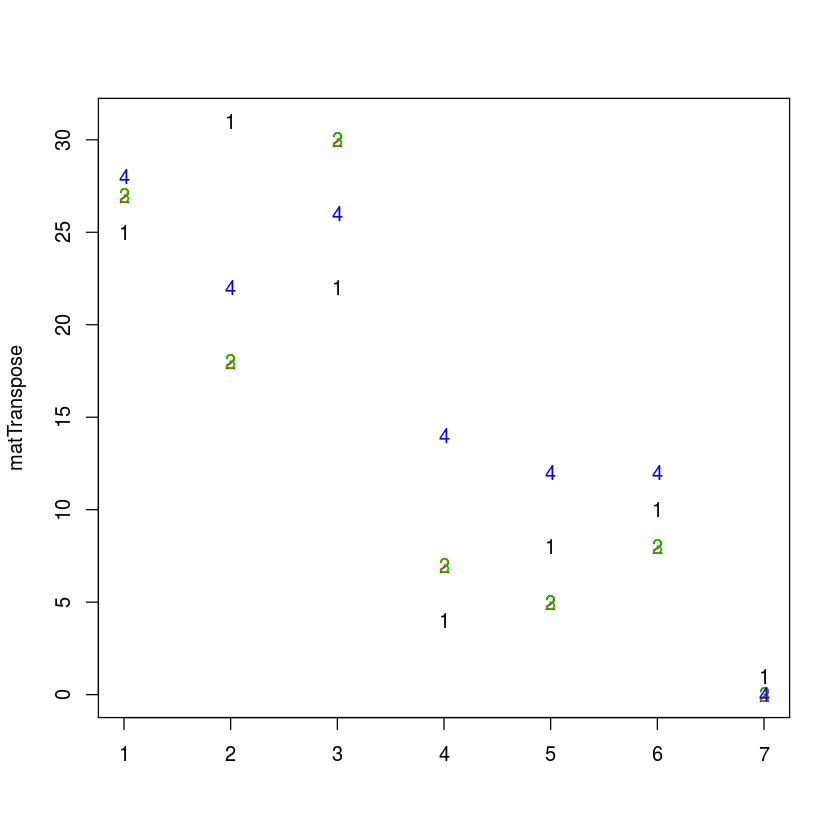

In [9]:
library(ggplot2)
columnNames=c("SHOTS","FACEOFF","HITS","TAKEAWAY","GIVEAWAY","PIM","PPG")
evalAt=round((sample.int(4,size=4,replace=TRUE)-1)/4*nrow(matchNYIMatrix),digits=0)
matTranspose=t(matchNYIMatrix[evalAt,])
#print(paste(nrow(matTranspose),ncol(matTranspose)))
matplot(matTranspose)

The different data categories vary in their range, which introduces an artificial weighing in the clustering process, which measures (in this case euclidean ($L_{2}$)) distances, calculated using the absolute numerical values of the category. Therefore we do a scaling, using the R function scale, which maps a vectors values to a vector with zero mean value and unit standard deviation.

In [10]:
matchNYIMatrixScaled<-scale(matchNYIMatrix)

Plotting a random choice of data values again, it shows that we are left with a more comparable dataset.

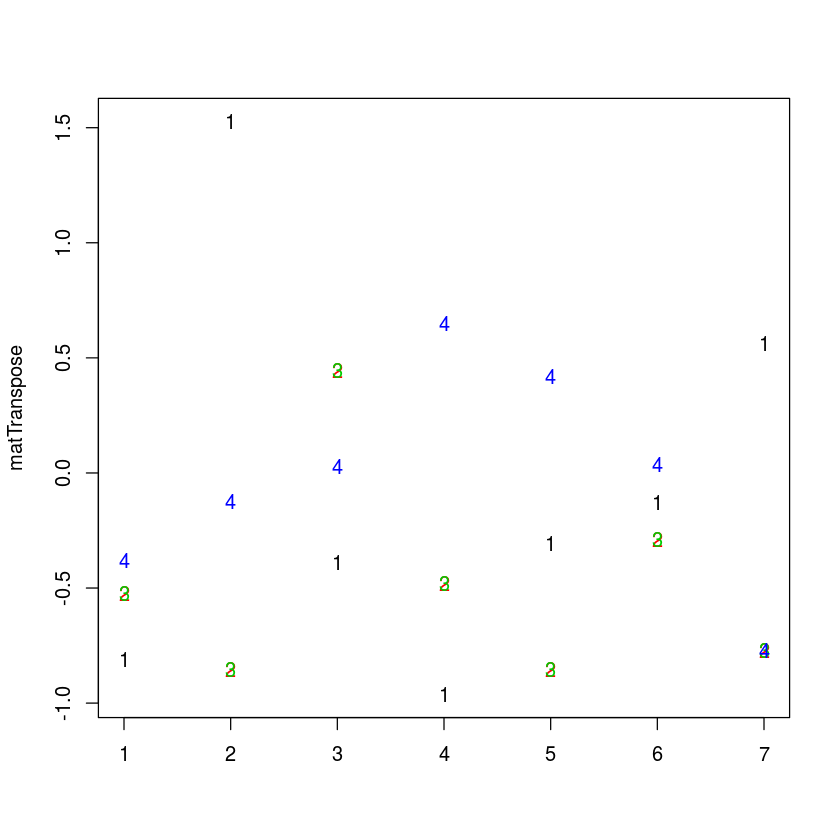

In [11]:
matTranspose=t(matchNYIMatrixScaled[evalAt,])
#print(paste(nrow(matTranspose),ncol(matTranspose)))
matplot(matTranspose)

## the k-means algorithm

We will classify the game data by using the k-means algorithm, which clusters datapoints around mean centroid values of cluster datasets.
As explained in algorithm 13.1 in [](#cite-zaki2014data), given the number of clusters to expect, say k, k points in d dimensional data space are selected as start values of cluster mean points. Clustering the data means to assign to each of these k points the nearest datapoints in the datasets, with nearest in the sense of the norm of a distance function. As we are left with k clusters, we compute in the next step the intra-cluster mean values, updating the initial k mean values. In the following we reassign all the points to the newly evaluated cluster means. This iterative procedure, when converged, optimally leads to k clearly distinctive clusters of datapoints.
A neat R library implementing clustering algorithms is fpc.

In [30]:
library(fpc)  
clusterResult=kmeansruns(matchNYIMatrixScaled,krange=1:22,criterion="ch",iter.max=100,runs=5,scaledata=FALSE,alpha=0.001,critout=FALSE,plot=FALSE)

In [31]:
print(paste("The algorithm has estimated the best kernel size to be",clusterResult$bestk))

[1] "The algorithm has estimated the best kernel size to be 2"


In [39]:
clusterResult=kmeansruns(matchNYIMatrixScaled,krange=2,criterion="ch",iter.max=100,runs=1,scaledata=FALSE,alpha=0.001,critout=FALSE,plot=FALSE)

To evaluate the results we do some data manipulation. We look at the distance between the found cluster centers and compare these differences with the span of the overall datarange.

In [15]:
  print("The algorithm found the following data cluster centers:")
  colnames=c("SHOTS","FACEOFF","HITS","TAKEAWAY","GIVEAWAY","PIM","PPG")
  
  sumClusterPoints=sum(clusterResult$size)
  for(i in 1:nrow(clusterResult$centers))
  {
    print(paste("cluster",i,"contains a fraction of",clusterResult$size[i]/sumClusterPoints,"points and has the following center values for the categories:"))
    for(j in 1:ncol(clusterResult$centers))
    {
      print(paste("center for category",colnames[j],"is",clusterResult$centers[i,j]))
    }
  }
  print("==================================")
  
  #now evaluate maximum distance measures
  print("evaluate maximum distance measures")
  print("==================================")
  
  for(j in 1:ncol(clusterResult$centers))
  {
    maxCenterDistance=max(clusterResult$centers[,j])-min(clusterResult$centers[,j])
    maxDataDistance=max(dataMatrix[,j])-min(dataMatrix[,j])
    print(paste("the maximum centroid distance for category ",colnames[j]," divided by max/min values is",maxCenterDistance/maxDataDistance))
  } 

[1] "The algorithm found the following data cluster centers:"
[1] "cluster 1 contains a fraction of 0.552036199095023 points and has the following center values for the categories:"
[1] "center for category SHOTS is -0.376942520461647"
[1] "center for category FACEOFF is -0.230860516204025"
[1] "center for category HITS is -0.331399588971615"
[1] "center for category TAKEAWAY is -0.616464615171551"
[1] "center for category GIVEAWAY is -0.600626572776056"
[1] "center for category PIM is 0.124787638541576"
[1] "center for category PPG is 0.0091795863581791"
[1] "cluster 2 contains a fraction of 0.447963800904977 points and has the following center values for the categories:"
[1] "center for category SHOTS is 0.464515025215363"
[1] "center for category FACEOFF is 0.284494777544353"
[1] "center for category HITS is 0.408391412672091"
[1] "center for category TAKEAWAY is 0.759683667181103"
[1] "center for category GIVEAWAY is 0.740166079582616"
[1] "center for category PIM is -0.15377870608

ERROR: Error in dataMatrix[, j]: subscript out of bounds


To check whether the different groups show a disparate scoring statistics we plot the scores as a scatter plot for the various datasets into one plot. 

In [70]:
#print(clusterResult$cluster)
#print(clusterResult$bestk)
dataCluster1 <- data.frame(matchNYI[which(clusterResult$cluster==1),],1)
#print(dataCluster1)
dataCluster2 <- data.frame(matchNYI[which(clusterResult$cluster==2),],2)
DATACAPTIONVEC <- c("ID","SEASON","DATE","WON","SCORE","SHOTS","FACEOFF","TAKEAWAY","GIVEAWAY","PIM","HITS","PPG","CLUSTER")
colnames(dataCluster1) <- DATACAPTIONVEC
colnames(dataCluster2) <- DATACAPTIONVEC
dataCluster <- rbind(dataCluster1,dataCluster2)
#dataClusters <- data.frame(dataCluster1,dataCluster2)
Cluster1Score=as.matrix(cbind(dataCluster1$WON,dataCluster1$SCORE))
Cluster2Score=as.matrix(cbind(dataCluster2$WON,dataCluster2$SCORE))
print(paste("in cluster 1 a game was won with probability: ",mean(Cluster1Score[,1]),"on average",mean(Cluster1Score[,2]),"goals were scored with an sd of",sd(Cluster1Score[,2])))
print(paste("in cluster 2 a game was won with probability: ",mean(Cluster2Score[,1]),"on average",mean(Cluster2Score[,2]),"goals were scored with an sd of",sd(Cluster2Score[,2])))

[1] "in cluster 1 a game was won with probability:  0.523076923076923 on average 3.01025641025641 goals were scored with an sd of 1.64344917525515"
[1] "in cluster 2 a game was won with probability:  0.54251012145749 on average 2.5587044534413 goals were scored with an sd of 1.55769632051029"


Looking at the results of games winning probability, mean values and standard deviations of goals scored, it seems evident that the clusters found do not divide game data into games won and lost, not even in high goal scoring events and moderate goal scoring events. The histogram of goals scored is plotted next.

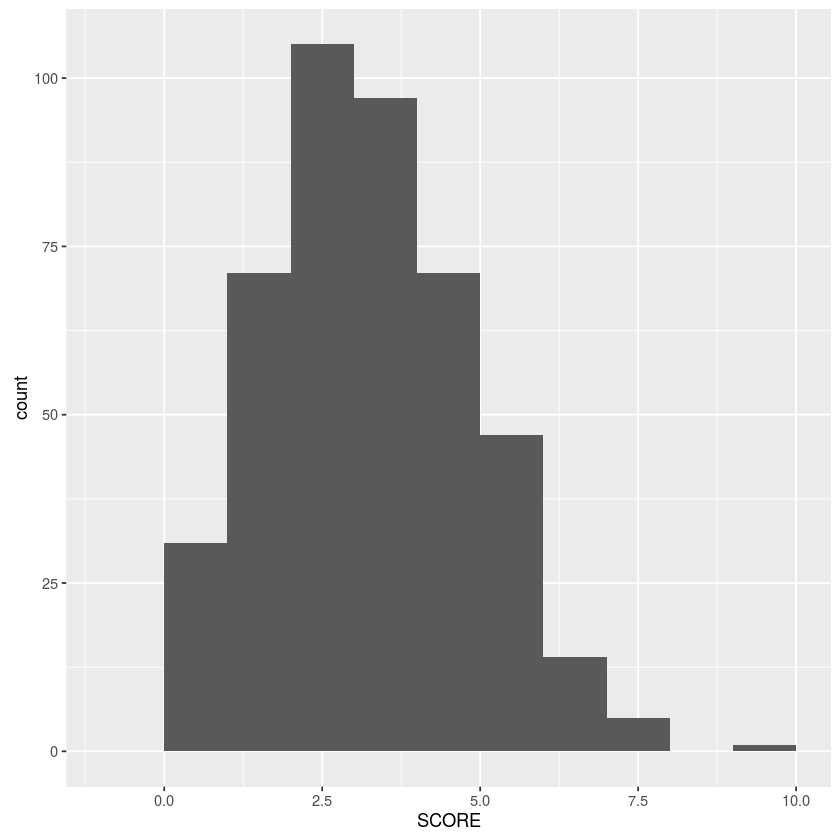

In [73]:
ggplot(dataCluster, aes(SCORE, fill = CLUSTER)) + geom_histogram(binwidth = 1)

## agglomerative clustering

In the next step we want to compare Islanders games and ask ourselves if we can find categorical similarities in games. To this end we apply an agglomerative clustering algorithm. As described in Zaki and Meira [](#cite-zaki2014data), the algorithm starts with N-datavectors  $x_{i=1..N} \in \mathbb{R}^{d}$. In a first step, using a chosen metric M, the distance between the N elements is computed and stored in a symmetric $N \times N$ matrix. Starting with N clusters, in each successive step nearest neighbours are combined, or agglomerated, into clusters. 

For our analysis we take the islanders home game data of the actual season, 2016. As starting dataset we choose the delta dataset $X_{\Delta}=X_{h}-X_{a}$ with $X_{h,a} \in X \in \mathbb{N}^{d}$ home and away team stats respectively. In the next, filtering step we intersect the dataset to get $X_{islanders} = \{X_{\Delta} \in X | x^{team}=NYI \cap    x^{season}=2016 \} $. In the resulting dataset we do not include the score information, as we want to know if the agglomerated clusters center around certain score values. The score is introduced in the labelling of the clusters aposteriori to indicate possible connections between multiple game stat values and the final outcome of the game.

In [77]:
tmp<-subset(nhlDataDelta,nhlDataSum$TEAM1=="NYI")
dataSubset<-subset(tmp,tmp$SEASON==2016)
dataMatrix <- as.matrix(cbind(dataSubset$SHOTS,dataSubset$PIM,dataSubset$PPG,dataSubset$TAKEAWAY,dataSubset$GIVEAWAY,dataSubset$HITS))
print(paste("In season 2016 we have ",nrow(dataMatrix),"Islanders home games so far, and collected information in",ncol(dataMatrix),"categories."))

[1] "In season 2016 we have  25 Islanders home games so far, and collected information in 6 categories."


Let's scale the data to avoid the introduction of a hidden weighing of the various attributes.

In [79]:
dataMatrixScaled=scale(dataMatrix)

The computation of the distance matrix is performed using the euclidean norm $L_{2}$.

In [80]:
  ddM=dist(dataMatrixScaled,method="euclidean")

We number the row numbers to get the correct game numbering and assemble the labels giving game number, team played against and the score difference, being positive for games won and negative for lost games.

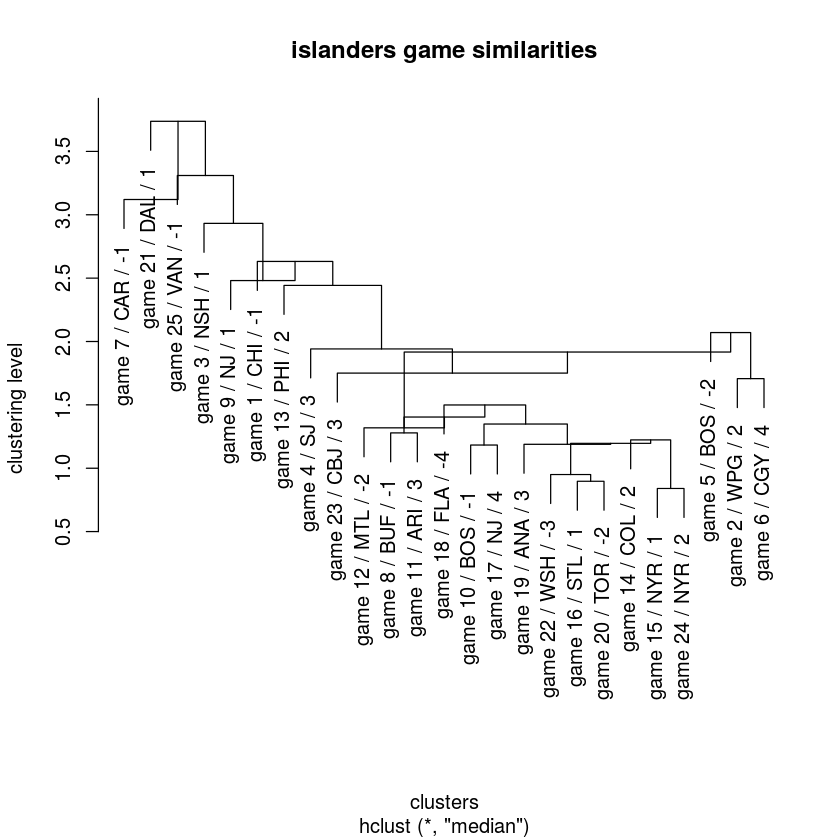

In [84]:
  rownames(dataSubset) <- 1:nrow(dataSubset)
  labelsV=as.vector(paste("game",rownames(dataSubset),"/",dataSubset$TEAM2,"/",dataSubset$SCORE))
  #hcm<-hclust(ddM,"median")
  plot(hcm,labels=labelsV,main="islanders game similarities",xlab="clusters",ylab="clustering level") 

The plot shows the game number, the team played against and the score difference, with a positive value indicating a win and a negative one a loss.
We see that the games 15 and 24 against the New York Rangers have similar statistics (are near in multivariate phase space) and have both been won. Game 14 against Colorado is also similar to theses games and has also been won with a two goals margin. The tight games on the upper left corner, game 7 against Carolina, game 21 against Dallas and Vancouver game 25, Nashville in game 3, New Jersey in game 9 and Chicago in game 1 have all been won or lost with one goal difference, and are neighbours in the plot, indicating a relationship which expands over the full set of attributes.